In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F

import torchvision as tv


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Работа с данными

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/ML/ML_files/mnist_train.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Краткий анализ

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


### Dataset и Dataloader

In [ ]:
ds = torch.tensor(df.values, dtype=torch.float32)
ds.shape

torch.Size([42000, 785])

In [ ]:
border = int(0.8*len(ds[:,0])) #для разделения на тренировочный и валидационный датасеты
print(border)
X = ds[:border,1:]/255 # нормализованный тензор значений пикселей
X = torch.tensor(X).reshape(-1, 1, 28, 28)
X = X.repeat(1, 3, 1, 1)
y = ds[:border,0]
train_dataset = torch.utils.data.TensorDataset(X, y) #создание датасета
print(X.shape)
print(y.shape)

33600


<ipython-input-111-c0b0fbfbcf8a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).reshape(-1, 1, 28, 28)


torch.Size([33600, 3, 28, 28])
torch.Size([33600])


In [ ]:
X = ds[border:,1:]/255 # нормализованный тензор значений пикселей
X = torch.tensor(X).reshape(-1, 1, 28, 28)
X = X.repeat(1, 3, 1, 1)
y = ds[border:,0]
val_dataset = torch.utils.data.TensorDataset(X, y)
print(X.shape)
print(y.shape)

<ipython-input-112-a819577bc1a2>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).reshape(-1, 1, 28, 28)


torch.Size([8400, 3, 28, 28])
torch.Size([8400])


## Преобразования данных для подачи на вход модели AlexNet

In [ ]:
transform = tv.transforms.Compose([
    tv.transforms.Resize((224, 224)),
    # tv.transforms.Normalize((0.1307,), (0.3081,))  # Нормализация данных MNIST
])

# Создание DataLoader с применением трансформаций
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Создание DataLoader с трансформацией
train_dataset = TransformDataset(train_dataset, transform=transform)
val_dataset = TransformDataset(val_dataset, transform=transform)

#### Визуализация данных из  тензора и датасета

In [ ]:
ds[0, 1:].numpy().reshape(28,28).shape

(28, 28)

tensor(3.)


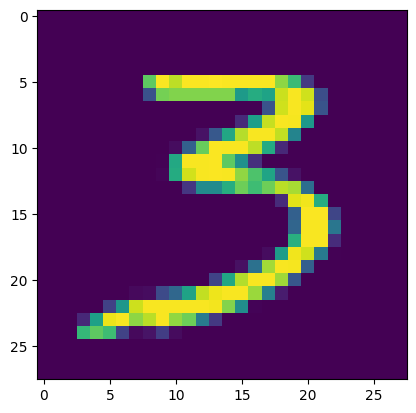

In [ ]:
plt.imshow(ds[25, 1:].numpy().reshape(28,28))
print(ds[25,0])

tensor(3.)


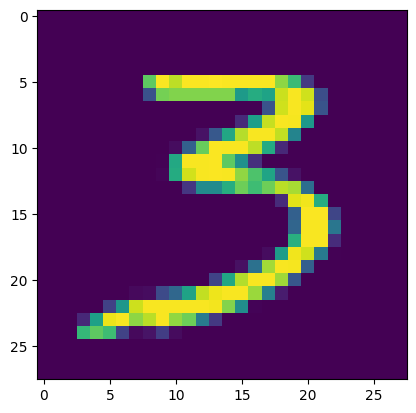

In [ ]:
plt.imshow(train_dataset[25][0].numpy().reshape(28,28))
print(train_dataset[25][1])

#### Создание загрузчика данных

In [ ]:
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
for digit, label in train_dataloader:
  print(digit.shape)
  print(label.shape)
  break


torch.Size([64, 3, 224, 224])
torch.Size([64])


# Нейронная сеть

###Модель

In [ ]:
device  = "cuda" if torch.cuda.is_available() else "cpu"
# device  = "cpu"
device

'cpu'

In [ ]:
model = tv.models.alexnet(pretrained=True).to(device)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
for param in model.parameters():
  param.requires_grad = False

In [ ]:
# Новый классификатор
classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(9216, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 1000),
    nn.ReLU(),
    nn.Linear(1000, 10)
)

In [ ]:
model.classifier = classifier

In [ ]:
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# функция потерь

loss_fn = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)
# model.parameters - веса и смещения модели
# momentum - чтобы не застревать в локальных минимумах

In [ ]:
def accuracy (prediction, label):
  answer = F.softmax(prediction.detach()).numpy().argmax(1) == label.numpy().argmax(1)
  # равны ли индексы максимальных элементов
  # print(answer)
  # print(answer.sum())
  return answer.mean()

### Обучение

In [ ]:
import time

max_acc = 0
model = model.to(device)
loss_fn = loss_fn.to(device)

epochs = 4
start_time = time.time()
for e in range(epochs):

  model.train()

  loss_train = 0
  acc_train = 0

  for digit, label in tqdm(train_dataloader):
    optimizer.zero_grad()

    digit = digit.to(device)
    label = label.to(device)

    # превращение label в вектор вероятностей (3 -> 00010000000)
    label = label.long() # так как аргумент one_hot должен быть целым
    label = F.one_hot(label, 10).float()

    # digit = digit.views(-1, 28*28)

    prediction = model(digit)

    loss = loss_fn(prediction, label)
    loss.backward() #подсчёт градиентов
    loss_train += loss.item()

    optimizer.step()

    acc_train += accuracy(prediction.cpu(), label.cpu())

  # Валидация модели после обучения на каждой эпохе
  acc_val = 0

  model.eval()

  for digit, label in val_dataloader:
      digit = digit.to(device)
      label = label.to(device)

      # превращение label в вектор вероятностей (3 -> 00010000000)
      label = label.long() # так как аргумент one_hot должен быть целым
      label = F.one_hot(label, 10).float()

      prediction = model(digit)

      acc_val += accuracy(prediction.cpu(), label.cpu())

  if (acc_val/len(val_dataloader)) > max_acc:
      print("-------------Сохраниение модели-------------")
      max_acc = acc_val/len(val_dataloader)
      torch.save(model, '/content/drive/MyDrive/Colab Notebooks/УИРС/alexnet_mnist_model2.pth')

  print(f'epoch: {e}, looss: {loss_train/len(train_dataloader)}, accuracy: {acc_train/len(train_dataloader)}')
  print(f'Accuracy val: {acc_val/len(val_dataloader)}')
end_time = time.time()
print("Время обучения:", end_time - start_time)

  0%|          | 0/525 [00:00<?, ?it/s]<ipython-input-17-d9b1963dfb08>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(prediction.detach()).numpy().argmax(1) == label.numpy().argmax(1)
  2%|▏         | 13/525 [00:34<22:55,  2.69s/it]


KeyboardInterrupt: 

2 лин слоя
<br>
cuda - 1 эпох - 74 сек - 0.98 )<br>
cuda - 3 эпох - 222 сек - 0.987<br>
<br>
4 лин слоя
cuda - 10 эпох - 660 сек - 0.988 )<br>


In [ ]:
# Загрузка весов сохраённой модели
weights = torch.load('/content/drive/MyDrive/Colab Notebooks/УИРС/alexnet_mnist_model.pth', map_location=torch.device('cpu'))
model.load_state_dict(weights.state_dict())

<All keys matched successfully>

### Валидация

In [ ]:
acc_val = 0

model.eval()
start_time = time.time()
for digit, label in val_dataloader:
    digit = digit.to(device)
    label = label.to(device)

    # превращение label в вектор вероятностей (3 -> 00010000000)
    label = label.long() # так как аргумент one_hot должен быть целым
    label = F.one_hot(label, 10).float()

    prediction = model(digit)

    acc_val += accuracy(prediction.cpu(), label.cpu())

end_time = time.time()
print(f'accuracy: {acc_val/len(val_dataloader)}')
print("Время обучения:", end_time - start_time)

<ipython-input-124-d9b1963dfb08>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(prediction.detach()).numpy().argmax(1) == label.numpy().argmax(1)


accuracy: 0.9883996212121212
Время обучения: 292.3998284339905


# Формирование  сабмита

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML/ML_files/mnist_test.csv')

In [ ]:
ds = torch.tensor(df.values, dtype=torch.float32) / 255.0
# нормализованный тензор значений пикселей
ds.shape

torch.Size([28000, 784])

In [ ]:
ds = df.values.astype(np.float32)
ds.shape

(28000, 784)

In [ ]:
ds = torch.tensor(ds).reshape(-1, 1, 28, 28)
ds = ds.repeat(1, 3, 1, 1)
ds.shape

<ipython-input-185-1c9c90dacb7e>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds = torch.tensor(ds).reshape(-1, 1, 28, 28)


torch.Size([28000, 3, 28, 28])

In [ ]:
# dataset = torch.utils.data.TensorDataset(ds)

In [ ]:
transform = tv.transforms.Compose([
    tv.transforms.Resize((224, 224)),
    # tv.transforms.Normalize((0.1307,), (0.3081,))  # Нормализация данных MNIST
])
class TestTransformDataset(torch.utils.data.Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image

In [ ]:
dataset = TestTransformDataset(ds, transform=transform)

In [ ]:
batch_size = 64
test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [ ]:
for batch in test_dataloader:
    print(f"Batch type: {type(batch)}")
    print(f"Batch size: {batch.size()}")
    break

Batch type: <class 'torch.Tensor'>
Batch size: torch.Size([64, 3, 224, 224])


In [ ]:
# Функция для получения предсказаний модели
def get_predictions(model, dataloader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images in test_dataloader:
            images = images.to(device)
            output = model(images)
            predictions.extend(output.argmax(1).cpu().numpy())

    return predictions

In [ ]:
start_time = time.time()
predicted_labels = get_predictions(model, test_dataloader)
end_time = time.time()
print("Время работы:", end_time - start_time)

Время работы: 952.3454139232635


In [ ]:
# Формирование submission DataFrame
submission_df = pd.DataFrame({
    'ImageId': np.arange(1, len(df) + 1),
    'Label': predicted_labels
})


In [ ]:
submission_df

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


4          

ValueError: cannot reshape array of size 50176 into shape (28,28)

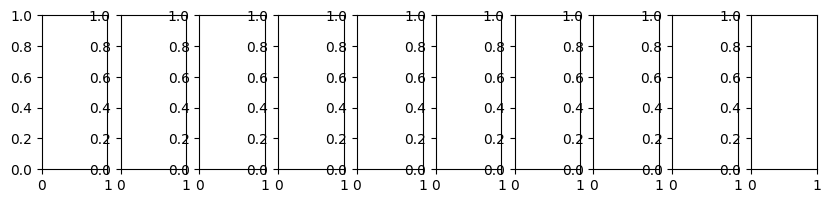

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 2))
for i in range (10):
  print(predicted_labels[i], end = '          ')
  axes[i].imshow(dataset[i][0].numpy().reshape(28,28))
  axes[i].axis('off')

In [ ]:
# Сохранение DataFrame в CSV файл
submission_df.to_csv('/content/drive/MyDrive/Colab Notebooks/УИРС/AlexNet_submission.csv', index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/УИРС/AlexNet_submission.csv')
df

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
